The MIT License (MIT)
Copyright (c) 2019 Massachusetts Institute of Technology

Author: Justin Li

This software is part of the NASA and NSF Projects (PI: V. Pankratius)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.

### "Machine Learning in Atmospheric Turbulence Detection: A Fusion Approach with GPS and MODIS”
This work was completed using the code provided in this notebook to conduct the data analysis for detecting atmospheric turbulence resulting from lee waves in the Sierra Nevada mountains. It calls upon the related scikit-dataaccess packages developed here at MIT Haystack Observatory.

In [2]:
import warnings
warnings.simplefilter("ignore")
from osgeo import gdal,osr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap

from skdaccess.geo.modis import DataFetcher
from skdaccess.framework.param_class import *
from skdaccess.utilities.modis_util import gps2pixel, rescale, check_bit

from theano import function, config, shared, sandbox
import theano.tensor as T
import time
import datetime
import os
import tqdm

import pickle
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.filters import gaussian_filter
from skimage.color import rgb2gray
from skimage import exposure
from scipy.misc import imresize

from TEC_Data import network3
from TEC_Data import MODIS_CNN_utils as mcu

import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu")

Using gpu device 0: Tesla K20c (CNMeM is disabled, cuDNN not available)


In [5]:
# Define the geographic region of interest
# Here, focusing on the Sierra Nevada mountains
lat_lon_coords = [37.839309, -119.137975]
vboset = 2.75; hboset = 3.75

In [16]:
# Define Parameters for Using GPS Data

# Start and end date for PBO GPS data
pbo_start_date = '2010-01-01'
pbo_end_date =   '2014-01-01'
# Region of interest for stabilization preprocessing
pbo_lat_range = lat_lon_coords[0]-vboset-10,lat_lon_coords[0]+vboset+10
pbo_lon_range = lat_lon_coords[1]-hboset-10,lat_lon_coords[1]+hboset+10
# Central point used to define a circular area of interest to grab GPS stations
ap_geopoint = AutoParam(lat_lon_coords)

# Radius of circle of interest (km)
ap_radius = AutoParam(500)

# Create the Data Fetcher to load the data
pbodf = PBODF(pbo_start_date, pbo_end_date, pbo_lat_range, pbo_lon_range,
              [ap_radius, ap_geopoint],mdyratio=.7,stab_flag=3,
              wrapper_type = 'table')

In [17]:
# Pulling the GPS data
itw = pbodf.output()
alldat = itw.get()

  0%|          | 0/1310 [00:00<?, ?it/s]

Opening /data/skdaccess/pbo_data.h5 in read-only mode


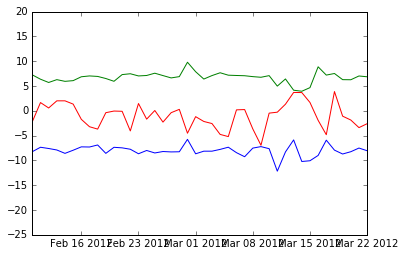

In [28]:
# Test Plot showing the East, North, and Vertical GPS data for station P134
plt.plot(alldat['P134'].dE);plt.plot(alldat['P134'].dN);plt.plot(alldat['P134'].dU);
plt.xlim('02-10-2012','03-22-2012');

In [32]:
# Load the MODIS data annotations denoting the regions with the visible atmospheric turbulence due to lee waves
# annotations were manually generated using a Python GUI

with open('1tmpSav_type3_A','rb') as rfp:
    alldata = pickle.load(rfp)
    
with open('1tmpSav_type3_B','rb') as rfp:
    alldata2 = pickle.load(rfp)

with open('1tmpSav_CODY.pkl','rb') as rfp:
    alldata2.extend(pickle.load(rfp))
    
with open('1tmpSav_CODYD.pkl','rb') as rfp:
    alldata2.extend(pickle.load(rfp))
    
with open('1tmpSav_type4','rb') as rfp:
    alldata3 = pickle.load(rfp)

In [4]:
# load the actual MODIS data and pull out the regions corresponding with the annotations
# applies data expansion to increase the number of positive examples, and also pulls out negative examples

imgdatas = []
imgclass = []

edN = 50; rDeg = 10; nFac = 0.2
for alin in alldata:
    if type(alin[2])!=int:
        data512,mask512 = mcu.tryWebGet(alin)
        aaa,bbb = mcu.getData_type3(data512,alin[2],mask=mask512,expandData=edN,rotateDeg=rDeg,noiseWeight=nFac,nnumM=0)

        for kk in np.arange(len(aaa)-1,0,-1):
            if np.any(np.isnan(aaa[kk])):
                if np.sum(np.isnan(aaa[kk]))==4096:
                    del aaa[kk]
                    del bbb[kk]
                else:
                    aaa[kk][np.isnan(aaa[kk])] = 0
        if len(imgdatas)==0:        
            imgdatas = np.array(aaa)
            imgclass = np.array(bbb)
        else:
            imgdatas = np.vstack((imgdatas,np.array(aaa)))
            imgclass = np.hstack((imgclass,np.array(bbb)))
            

# additional data set (Terra+Terra-Cody)
for alin in alldata2:
    if type(alin[2])!=int:
        data512,mask512 = mcu.tryWebGet(alin)
        aaa,bbb = mcu.getData_type3(data512,alin[2],mask=mask512,expandData=edN,rotateDeg=rDeg,noiseWeight=nFac,nnumM=0)

        for kk in np.arange(len(aaa)-1,0,-1):
            if np.any(np.isnan(aaa[kk])):
                if np.sum(np.isnan(aaa[kk]))==4096:
                    del aaa[kk]
                    del bbb[kk]
                else:
                    aaa[kk][np.isnan(aaa[kk])] = 0
        imgdatas = np.vstack((imgdatas,np.array(aaa)))
        imgclass = np.hstack((imgclass,np.array(bbb)))
        
for alin in alldata3:
    if alin[2]!=-1:
        data512,mask512 = mcu.tryWebGet(alin)
    if type(alin[2])!=int:
        aaa,bbb = mcu.getData_type3(data512,alin[2],mask=mask512,expandData=edN*4,rotateDeg=rDeg,noiseWeight=nFac,nnumM=2)
    elif alin[2] == 0:
        aaa,bbb = mcu.getNoise_type3(data512,mask=mask512,nsamp=20,expandData=edN,rotateDeg=rDeg,noiseWeight=nFac)
        aaa,bbb = mcu.getAllTiles(data512,mask=mask512)
    if alin[2] != -1:
        for kk in np.arange(len(aaa)-1,0,-1):
            if np.any(np.isnan(aaa[kk])):
                if np.sum(np.isnan(aaa[kk]))==4096:
                    del aaa[kk]
                    del bbb[kk]
                else:
                    aaa[kk][np.isnan(aaa[kk])] = 0
        
        if len(imgdatas)==0:        
            imgdatas = np.array(aaa)
            imgclass = np.array(bbb)
        else:
            imgdatas = np.vstack((imgdatas,np.array(aaa)))
            imgclass = np.hstack((imgclass,np.array(bbb)))
        
        
# randomizes the complete data set, and the labels accordingly
neworder = np.random.choice(np.arange(len(imgclass)),len(imgclass),replace=False)
imgdatas = imgdatas[neworder,:]
imgclass = imgclass[neworder]

In [7]:
# sanity check on the total size of the data
imgdatas.shape

(305627, 4096)

In [8]:
# split the data in training, validation, and test data
npt1 = 250000; npt2=npt1+30000; npt3=npt2+20000
training_data   = shared(imgdatas[:npt1,:].astype('float32')), T.cast(shared(imgclass[:npt1].flatten()), "int32")
validate_data   = shared(imgdatas[npt1:npt2,:].astype('float32')), T.cast(shared(imgclass[npt1:npt2].flatten()), "int32")
testing_data    = shared(imgdatas[npt2:npt3,:].astype('float32')), T.cast(shared(imgclass[npt2:npt3].flatten()), "int32")

In [452]:
# set up the convolutional neural network using the Theano package
# as described in the paper, the network has two convolutional and max pool layers, followed by two fully connected layers
mini_batch_size = 10
net2 = network3.Network([network3.ConvPoolLayer(image_shape=(mini_batch_size, 1, 64, 64), 
                                                filter_shape=(40, 1, 9, 9), 
                                                poolsize=(2, 2)),
                         network3.ConvPoolLayer(image_shape=(mini_batch_size, 40, 28, 28), 
                                                filter_shape=(20, 40, 5, 5), 
                                                poolsize=(2, 2)),
                         network3.FullyConnectedLayer(n_in=20*12*12, n_out=1000),
                         network3.SoftmaxLayer(n_in=1000, n_out=100)], mini_batch_size)

# try some initial training, with verbose output to verify that training is occurring
net2.SGD(training_data, 2, mini_batch_size, 0.1, validate_data, testing_data);

Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Epoch 0: validation accuracy 84.44%
This is the best validation accuracy to date.
The corresponding test accuracy is 84.25%
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-batch number 19000
Epoch 1: validation accuracy 93.41%
This is the best validation accuracy to date.
The corresponding test accuracy is 93.55%
Finished training network.
Best validation accuracy of 93.41% obtained at iteration 19999
Corresponding t

In [453]:
# continue training, with verbose off, for longer durations
# and also varying the learning rate
net2.SGD(training_data, 10, mini_batch_size, 0.01, validate_data, testing_data,verbose=False);

Finished training network.
Best validation accuracy of 96.01% obtained at iteration 99999
Corresponding test accuracy of 96.13%


In [461]:
net2.SGD(training_data, 10, mini_batch_size, 0.00000001, validate_data, testing_data,verbose=False);

Finished training network.
Best validation accuracy of 96.23% obtained at iteration 99999
Corresponding test accuracy of 96.36%


In [508]:
test_y = net2.predict_Ttype(testing_data[0])
print('Test Accuracy of '+str(np.round((1-np.sum(np.abs(np.array(test_y).flatten() - testing_data[1].eval()))/20000)*100,1))+'%')

Test Accuracy of 96.4%


In [ ]:
# Visual evaluation of the results
# first pull the full image data, saving also the results of the CNN applied to that image

eachImg = []
eachRes = []
eimgIdx = []
eachLbl = []

for idx,alin in tqdm.tqdm(enumerate(alldata3)):
    if alin[2] != -1:
        data512,mask512 = mcu.tryWebGet(alin)
        imgres = mcu.testImage(data512,mask512,net2)
        eachImg.append([data512,mask512])
        eachRes.append(imgres)
        eimgIdx.append(idx)
        if alin[2] == 0:
            eachLbl.append(0)
        else:
            eachLbl.append(1)

41it [27:34,  0.02it/s]

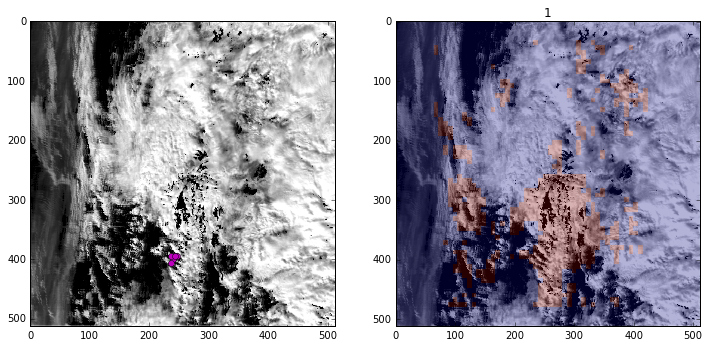

In [441]:
# viewing some example cases, as indexed by idx
# left plot shows the data and the manually detected points
# right plot shows the overlaid cnn detections, with the ground truth lable on top

idx = 7
data512,mask512 = eachImg[idx]
plt.figure(figsize=(12,12));plt.subplot(121);plt.imshow(rgb2gray(rescale(data512))*mask512,cmap=plt.cm.binary_r);
if type(alldata3[eimgIdx[idx]][2])!=int:
    plt.plot(np.array(alldata3[eimgIdx[idx]][2])[:,0],np.array(alldata3[eimgIdx[idx]][2])[:,1],'m.',markersize=12,markeredgecolor='k');
plt.xlim(0,512);plt.ylim(512,0);plt.clim(0,1);
plt.subplot(122);plt.imshow(rgb2gray(rescale(data512))*mask512,cmap=plt.cm.binary_r);plt.title(eachLbl[idx]);
plt.imshow(imresize(np.pad(eachRes[idx][0],(4,4),'constant',constant_values=(0,0)),(512,512),interp='nearest'),alpha=.3,interpolation='None');

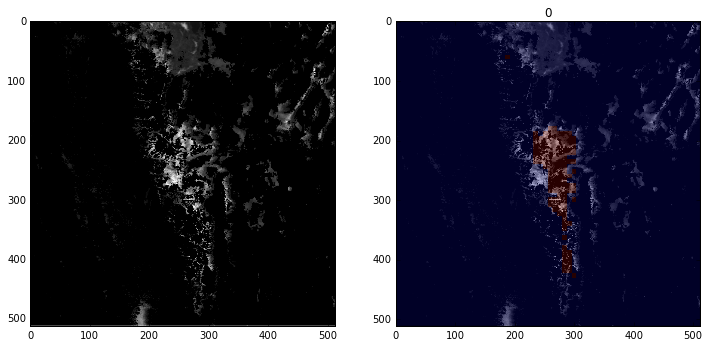

In [327]:
# another example -- failure mode due to the snow pattern

idx = 9
data512,mask512 = eachImg[idx]
plt.figure(figsize=(12,12));plt.subplot(121);plt.imshow(rgb2gray(rescale(data512))*mask512,cmap=plt.cm.binary_r);
if type(alldata3[eimgIdx[idx]][2])!=int:
    plt.plot(np.array(alldata3[eimgIdx[idx]][2])[:,0],np.array(alldata3[eimgIdx[idx]][2])[:,1],'m.',markersize=12,markeredgecolor='k');
plt.xlim(0,512);plt.ylim(512,0);plt.clim(0,1);
plt.subplot(122);plt.imshow(rgb2gray(rescale(data512))*mask512,cmap=plt.cm.binary_r);plt.title(eachLbl[idx]);
plt.imshow(imresize(np.pad(eachRes[idx][0],(4,4),'constant',constant_values=(0,0)),(512,512),interp='nearest'),alpha=.3,interpolation='None');

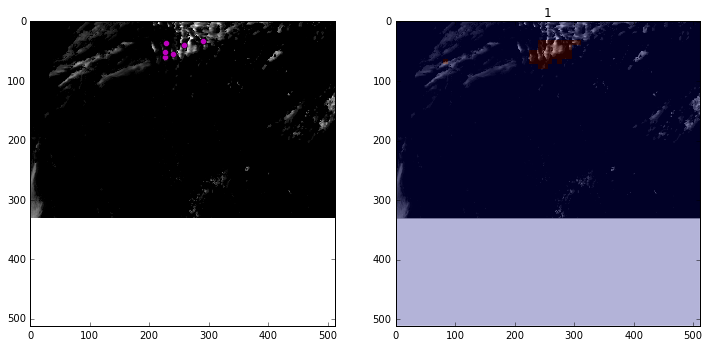

In [153]:
# another example

idx = 0
data512,mask512 = eachImg[idx]
plt.figure(figsize=(12,12));plt.subplot(121);plt.imshow(rgb2gray(rescale(data512))*mask512,cmap=plt.cm.binary_r);
if idx<10:
    plt.plot(np.array(alldata[eimgIdx[idx]][2])[:,0],np.array(alldata[eimgIdx[idx]][2])[:,1],'m.',markersize=12,markeredgecolor='k');
else:
    if type(alldata3[eimgIdx[idx]][2])!=int:
        plt.plot(np.array(alldata3[eimgIdx[idx]][2])[:,0],np.array(alldata3[eimgIdx[idx]][2])[:,1],'m.',markersize=12,markeredgecolor='k');
plt.xlim(0,512);plt.ylim(512,0);plt.clim(0,1);
plt.subplot(122);plt.imshow(rgb2gray(rescale(data512))*mask512,cmap=plt.cm.binary_r);plt.title(eachLbl[idx]);
plt.imshow(imresize(np.pad(eachRes[idx][0],(4,4),'constant',constant_values=(0,0)),(512,512),interp='nearest'),alpha=.3,interpolation='None');

In [ ]:
# Load the skew and outlier data

In [17]:
skewss = pd.read_hdf('/home/cmrude/Notebooks/Lee Waves/skews.hdf',key='skew')

Opening /home/cmrude/Notebooks/Lee Waves/skews.hdf in read-only mode


In [18]:
skewss.head()

,Mag,Lat,Lon,dE,dN
Station,,,,,
P272,0.165357,39.145482,-121.943063,-0.159585,-0.043309
P228,0.383875,37.601836,-121.686937,-0.354870,0.146382
P469,0.479326,37.231425,-117.935810,-0.260636,-0.402272
P285,0.119065,36.417180,-120.981482,-0.050640,-0.107759
P306,0.214628,37.795168,-120.644459,-0.210486,-0.041960


In [19]:
ccc = pd.read_hdf('/home/cmrude/Notebooks/Lee Waves/outlier_index.hdf',key='outlier_index')

Opening /home/cmrude/Notebooks/Lee Waves/outlier_index.hdf in read-only mode


In [21]:
ccc[:,:,'CMBB'].head()

,MAD_Scale_dN,MAD_Scale_dE,MAD_Scale_dU
2002-01-01,1.011735,2.716026,1.302735
2002-01-02,2.252541,1.722358,1.319654
2002-01-03,0.814478,0.090333,0.300024
2002-01-04,1.285348,2.131869,0.212047
2002-01-05,0.814478,0.439623,0.011279


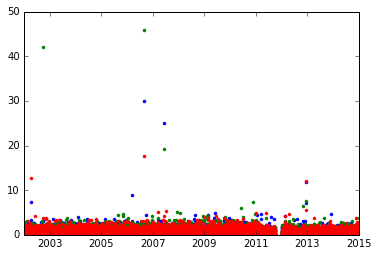

In [22]:
# inspecting the skew and outlier above
# ploting the outliers for one station and noting that some days are the outliers
plt.plot(ccc[:,:,'CMBB'],'.');

In [541]:
# picking a particular day to examine
alldata3[eimgIdx[0]][0]

'2012-01-03'

In [666]:
# grab the same day from the outlier data
np.where(ccc.major_axis==alldata3[eimgIdx[6]][0])[0][0]

3670

In [742]:
# look at the magnitude of the outlier, as opposed to its components
cmags = np.sqrt(np.sum(ccc.iloc[:,3670,:]**2,axis=1))

In [744]:
# looking at if there's a threshold for the outlier score to count a station as an outlier 
from skimage import filters
val = filters.threshold_otsu(cmags)

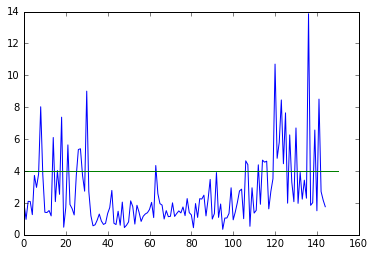

In [745]:
# comparing the station outlier scores for the otsu's threshold
plt.plot(np.array(cmags));
plt.plot([0,150],[val,val]);

In [762]:
# create a map via Basemap
vboset = 2; hboset = 2
m = Basemap(projection='gnom',lat_0=lat_lon_coords[0],lon_0=lat_lon_coords[1],
            urcrnrlat=lat_lon_coords[0]+vboset,llcrnrlat=lat_lon_coords[0]-vboset,
            urcrnrlon=lat_lon_coords[1]+hboset,llcrnrlon=lat_lon_coords[1]-hboset,
            resolution='i')

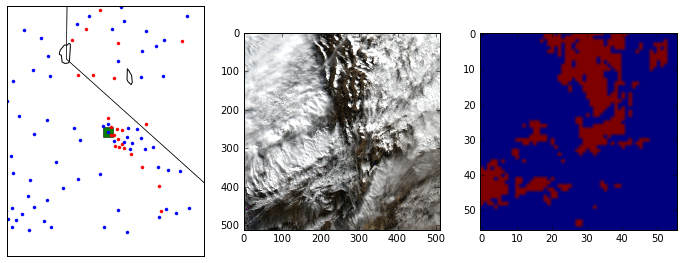

In [765]:
# plot out the map of these thresholded stations and compare visually with the MODIS imagery and CNN detections
plt.figure(figsize=(12,12));plt.subplot(131);
m.drawcoastlines();
m.drawstates();
# m.drawrivers();
m.plot(lat_lon_coords[1],lat_lon_coords[0],'gs',markersize=10,latlon=True);
for asite in cmags.keys():
    if cmags[asite]>val:
        m.plot(skewss.loc[asite].Lon,skewss.loc[asite].Lat,'r.',latlon=True);
    else:
        m.plot(skewss.loc[asite].Lon,skewss.loc[asite].Lat,'b.',latlon=True);
# plt.colorbar();
plt.subplot(132);plt.imshow(rescale(eachImg[6][0]));
plt.subplot(133);plt.imshow(eachRes[6][0]);

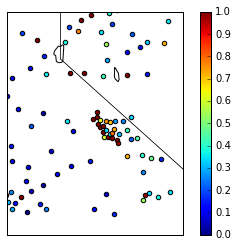

In [695]:
# look at how the station outlier scores are distributed geographically
m.drawcoastlines();
m.drawstates();
# m.drawrivers();
for asite in cmags.keys():
    m.scatter(skewss.loc[asite].Lon,skewss.loc[asite].Lat,c=skewss.loc[asite].Mag,vmin=0,vmax=1,latlon=True);
plt.colorbar();